In [12]:
# !pip install 'zarr<3'
# !pip install timm
# !pip install openslide-python tiffslide
# !pip install cupy-cuda12x  # for CUDA 12.x

In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")


✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


## WSI

In [2]:
import torch
from vitaminp import VitaminPFlex
from vitaminp.inference import ChannelConfig, WSIPredictor
# Setup model
device = 'cuda'
model = VitaminPFlex(model_size='large').to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_flex_large_fold2_best.pth", map_location=device))
model.eval()

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]


VitaminPFlex(
  (backbone): DINOv2Backbone(
    (dinov2): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): M

## HE or mIF

In [9]:
from vitaminp.inference.channel_config import ChannelConfig
from vitaminp.inference import WSIPredictor

# Create channel config
config = ChannelConfig(
    nuclear_channel=0,  # SYTO 13
    membrane_channel=[1, 2],  # Combine all markers
    membrane_combination='max',
    channel_names={0: 'SYTO13', 1: 'Cy3', 2: 'TexasRed'}
)

# Create predictor with MIF config
predictor = WSIPredictor(
    model=model,
    device='cuda',
    patch_size=512,
    overlap=64,
    target_mpp=0.5013,           # ← Default MPP (used if no metadata)
    magnification=20,          # ← Default magnification
    mif_channel_config=config
)

# Run MIF inference with MPP-aware filtering
results = predictor.predict(
    wsi_path='test_images/test_resized_1024.png',
    output_dir='results_new',
    branch='he_nuclei',
    filter_tissue=False,
    # tissue_threshold=0.03,
    clean_overlaps=True,
    save_geojson=True,
    detection_threshold=0.4,      # ← Binary threshold (0.5-0.8)
    min_area_um=2.0,              # ← NEW: Biological size filter in μm²
    # mpp_override=0.5,           # ← Optional: Force specific MPP
)

print(f"✅ Found {results['num_detections']} nuclei in {results['processing_time']:.2f}s")
print(f"   Output saved to: {results['output_dir']}")

# Check if any instances have area info
if results['num_detections'] > 0:
    first_cell = list(results['instances'].values())[0]
    if 'area_um' in first_cell:
        print(f"   First cell area: {first_cell['area_um']:.2f} μm² ({first_cell['area_pixels']:.0f} pixels²)")

2026-01-17 19:42:18 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-17 19:42:18 - WSIPredictor - INFO -   Device: cuda
2026-01-17 19:42:18 - WSIPredictor - INFO -   Patch size: 512
2026-01-17 19:42:18 - WSIPredictor - INFO -   Overlap: 64
2026-01-17 19:42:18 - WSIPredictor - INFO -   Magnification: 20
2026-01-17 19:42:18 - WSIPredictor - INFO -   MIF channels: Nuclear: SYTO13, Membrane: max(Cy3, TexasRed)
2026-01-17 19:42:19 - WSIPredictor - INFO -    ⚠ No MPP in metadata, using default: 0.5013 μm/px
2026-01-17 19:42:19 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 8 pixels²
2026-01-17 19:42:19 - WSIPredictor - INFO - 📁 Opening WSI: test_images/test_resized_1024.png
2026-01-17 19:42:19 - WSIPredictor - INFO -    ✓ Size: 896x896 pixels
2026-01-17 19:42:19 - WSIPredictor - INFO - 📐 Extracting tile positions...
2026-01-17 19:42:19 - WSIPredictor - INFO -    ✓ Created 4 tiles (2x2 grid)
2026-01-17 19:42:19 - WSIPredictor - INFO - 🧠 Running predictions and extracting insta

   Scanning 2x2 tile grid...


Processing tiles: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]
2026-01-17 19:42:21 - WSIPredictor - INFO -    ✓ Extracted 1416 instances from tiles (before cleaning)
2026-01-17 19:42:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-17 19:42:21 - WSIPredictor - INFO -    Found 448 edge cells to check for overlaps
2026-01-17 19:42:21 - WSIPredictor - INFO - Starting overlap cleaning with 1416 detections
2026-01-17 19:42:21 - WSIPredictor - INFO - Split detections: 0 mid, 1416 edge
2026-01-17 19:42:21 - WSIPredictor - INFO - Iteration 1: Found 331 overlaps, keeping 1085/1416 detections
2026-01-17 19:42:21 - WSIPredictor - INFO - Iteration 2: Found 13 overlaps, keeping 1072/1085 detections
2026-01-17 19:42:21 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 1072/1072 detections
2026-01-17 19:42:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-17 19:42:21 - WSIPredictor - INFO - Cleaning complete: 1416 -> 1072 

✅ Found 1072 nuclei in 3.29s
   Output saved to: results_new


In [12]:
import cv2
# 1. Load the extracted patch (that fails)
extracted = cv2.imread('results/debug_patches/input_0012_x0_y448.png')

# 2. Save it without any viewing
cv2.imwrite('test_images/test_direct.png', extracted)

# 3. Open test_direct.png in Preview, take a screenshot, run inference
# Does the screenshot work but test_direct.png fail?

# 4. Also try: resize the extracted patch programmatically
extracted_resized = cv2.resize(extracted, (1024, 1024))
cv2.imwrite('test_images/test_resized_1024.png', extracted_resized)

# Run inference on test_resized_900.png
# Does this work?

True

Original slide dimensions: (21912, 12917)
MPP: 0.50129999999999997
Extracting region at (8456, 3958) with size 5000x5000
✅ Saved to: test_images/MS004_HE_center_5000x5000.png
   Size: (5000, 5000)


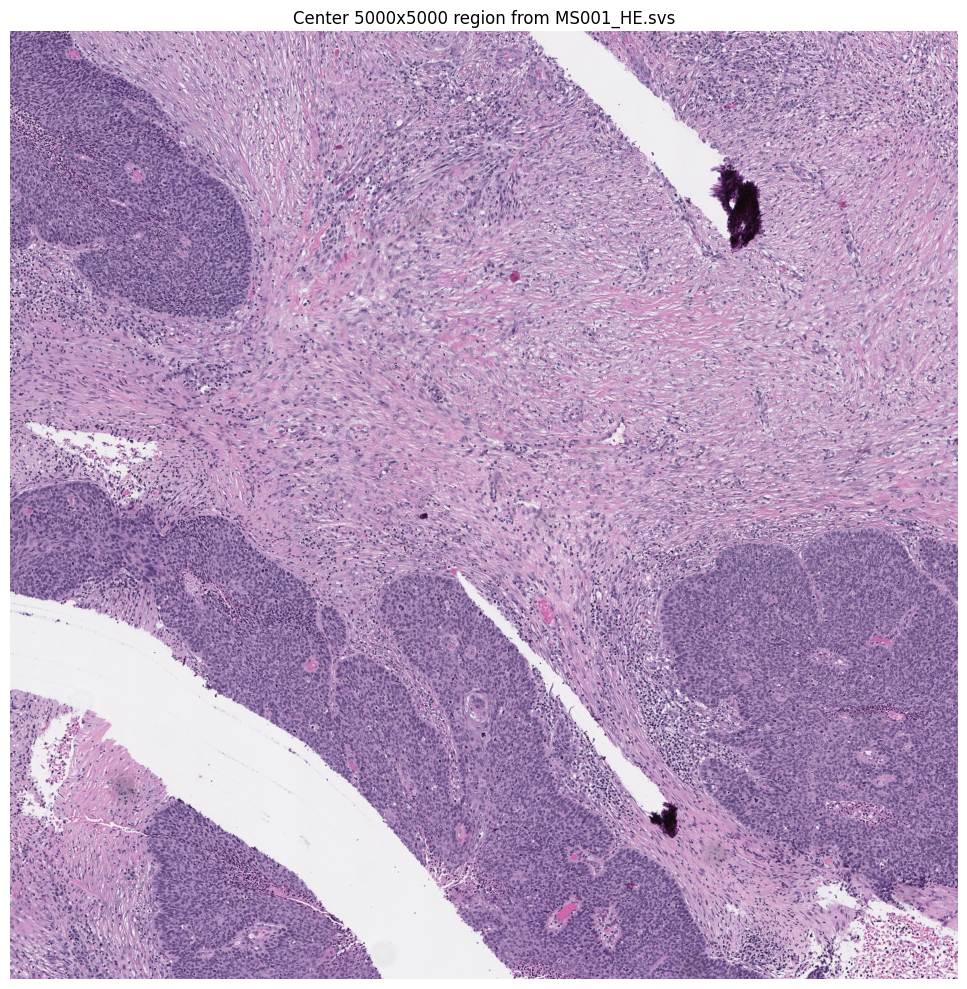


📁 Created files:
   - test_images/MS001_HE_center_5000x5000.png (full resolution)
   - test_images/MS001_HE_center_preview.png (preview)


In [15]:
# Extract a 5000x5000 region from center of SVS and save it
import openslide
import numpy as np
from PIL import Image
from pathlib import Path

# Open the SVS file
slide = openslide.OpenSlide('test_images/MS004_HE.svs')

print(f"Original slide dimensions: {slide.dimensions}")
print(f"MPP: {slide.properties.get('openslide.mpp-x', 'N/A')}")

# Calculate center region (5000x5000)
width, height = slide.dimensions
region_size = 5000

center_x = (width - region_size) // 2
center_y = (height - region_size) // 2

print(f"Extracting region at ({center_x}, {center_y}) with size {region_size}x{region_size}")

# Read the region
region = slide.read_region((center_x, center_y), 0, (region_size, region_size))
region_rgb = region.convert('RGB')

# Save as PNG (can't save as SVS without special tools)
output_path = Path('test_images/MS004_HE_center_5000x5000.png')
region_rgb.save(output_path)

print(f"✅ Saved to: {output_path}")
print(f"   Size: {region_rgb.size}")

# Also show preview
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.array(region_rgb))
ax.set_title(f'Center 5000x5000 region from MS001_HE.svs')
ax.axis('off')
plt.tight_layout()
plt.savefig('test_images/MS004_HE_center_preview.png', dpi=100, bbox_inches='tight')
plt.show()

slide.close()

print("\n📁 Created files:")
print("   - test_images/MS001_HE_center_5000x5000.png (full resolution)")
print("   - test_images/MS001_HE_center_preview.png (preview)")

Testing binary_threshold + min_size combinations:
🔍 DEBUG: After remove_small_objects with min_size=10, blb has 17861 pixels
Binary=0.5, MinSize= 10:  71 →  71 cells (removed 0)
🔍 DEBUG: After remove_small_objects with min_size=10, blb has 17861 pixels
Binary=0.5, MinSize= 50:  71 →  67 cells (removed 4)
🔍 DEBUG: After remove_small_objects with min_size=10, blb has 17861 pixels
Binary=0.5, MinSize=100:  71 →  48 cells (removed 23)
🔍 DEBUG: After remove_small_objects with min_size=10, blb has 17861 pixels
Binary=0.5, MinSize=200:  71 →  17 cells (removed 54)
🔍 DEBUG: After remove_small_objects with min_size=10, blb has 16391 pixels
Binary=0.7, MinSize= 10:  68 →  68 cells (removed 0)
🔍 DEBUG: After remove_small_objects with min_size=10, blb has 16391 pixels
Binary=0.7, MinSize= 50:  68 →  61 cells (removed 7)
🔍 DEBUG: After remove_small_objects with min_size=10, blb has 16391 pixels
Binary=0.7, MinSize=100:  68 →  43 cells (removed 25)
🔍 DEBUG: After remove_small_objects with min_size=1

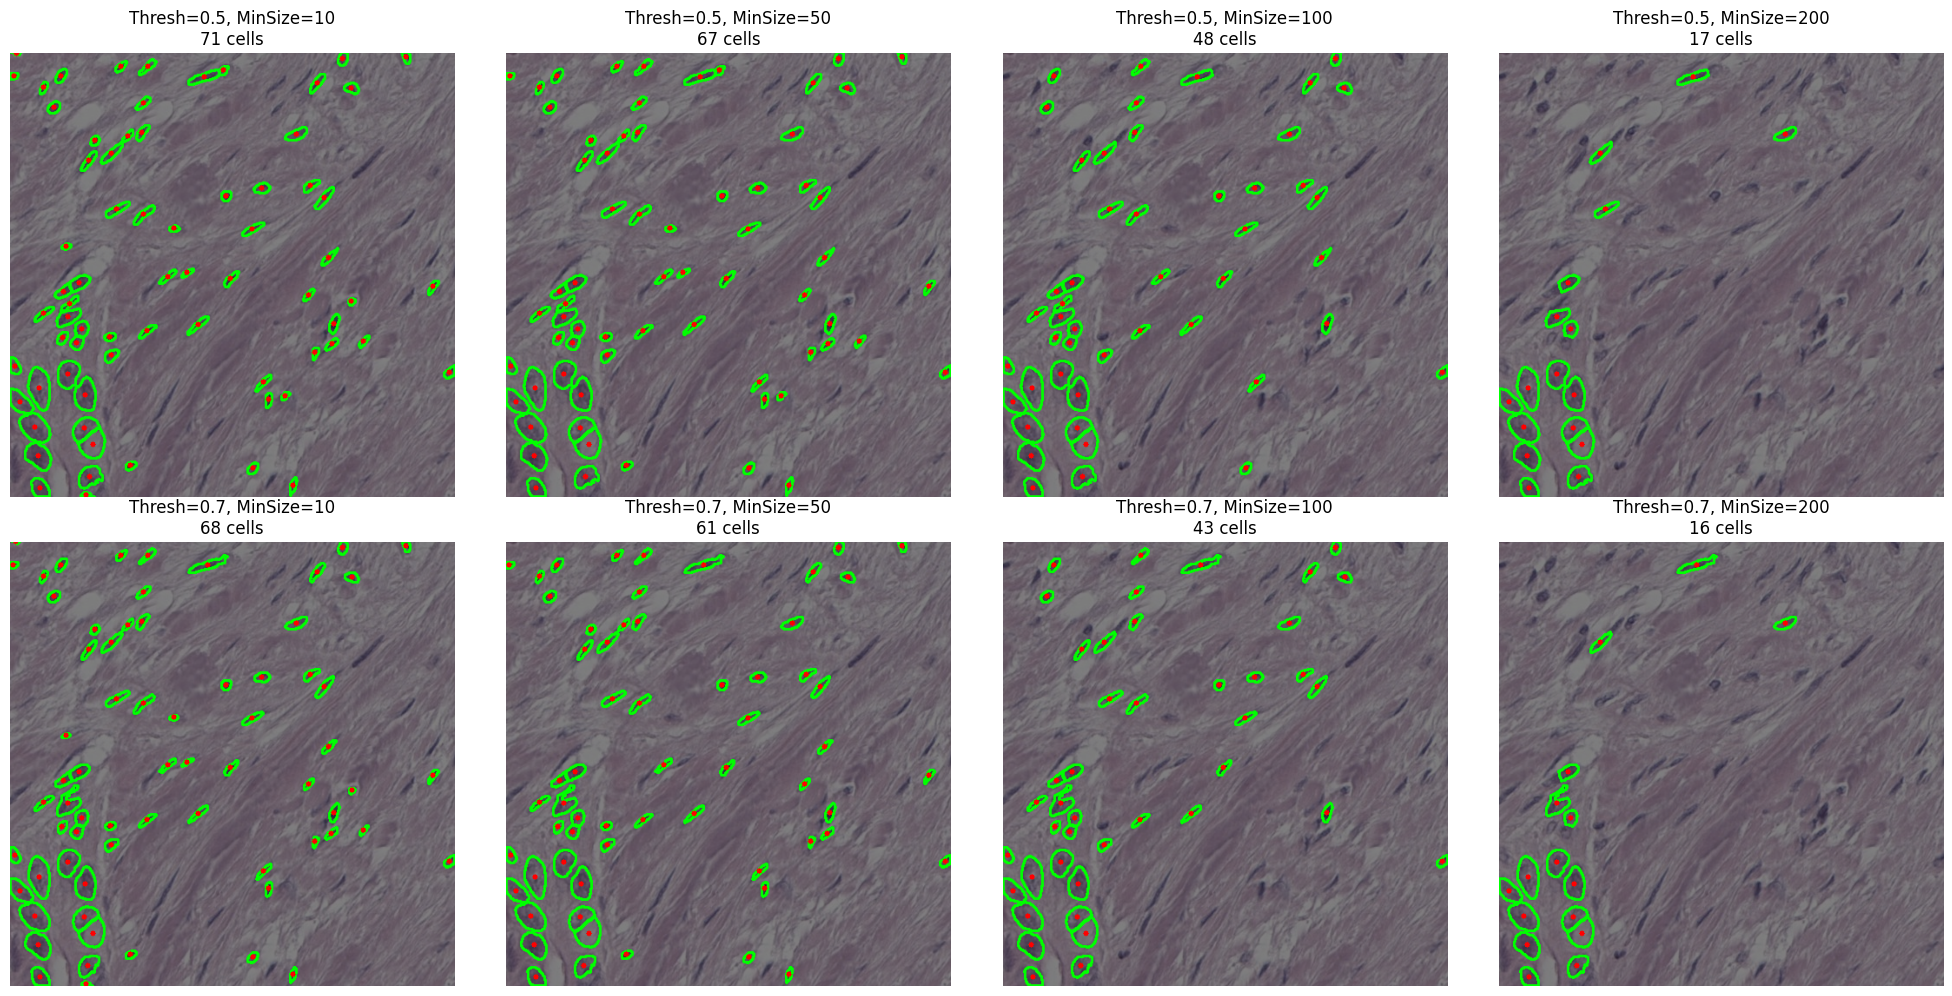


DETAILED STATISTICS:

Binary Threshold = 0.5
------------------------------------------------------------
  MinSize= 10:  71 cells | Area range: 20-900 | Mean area: 197
  MinSize= 50:  67 cells | Area range: 53-900 | Mean area: 207
  MinSize=100:  48 cells | Area range: 102-900 | Mean area: 258
  MinSize=200:  17 cells | Area range: 204-900 | Mean area: 472

Binary Threshold = 0.7
------------------------------------------------------------
  MinSize= 10:  68 cells | Area range: 12-866 | Mean area: 190
  MinSize= 50:  61 cells | Area range: 53-866 | Mean area: 207
  MinSize=100:  43 cells | Area range: 100-866 | Mean area: 261
  MinSize=200:  16 cells | Area range: 200-866 | Mean area: 472


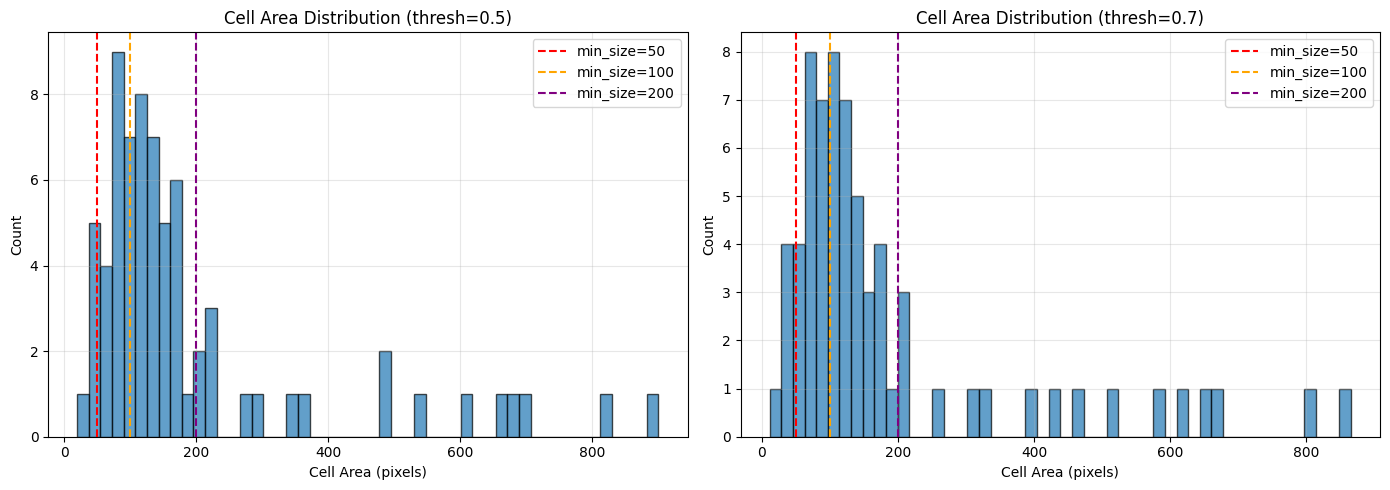


✅ Done! Check the saved images:
   - size_filtering_comparison.png
   - area_distribution.png


In [5]:
# Complete test cell with predictions included
import numpy as np
import matplotlib.pyplot as plt
from vitaminp.postprocessing.hv_postprocess import HVPostProcessor
import cv2
import torch
from vitaminp import prepare_he_input, SimplePreprocessing

# 1. Load image and run model
tile = predictor.wsi_handler.get_wsi_reader('test_images/CRC31-he_chunk_38.png')
tile_img = tile.read_region((0, 0), (512, 512))
tile.close()

# Prepare input
tile_tensor = torch.from_numpy(tile_img.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to('cuda')
tile_tensor = prepare_he_input(tile_tensor)
tile_tensor = SimplePreprocessing().percentile_normalize(tile_tensor)

# Run model
with torch.no_grad():
    outputs = model(tile_tensor)

seg_pred = outputs['he_nuclei_seg'][0, 0].cpu().numpy()
h_map = outputs['he_nuclei_hv'][0, 0].cpu().numpy()
v_map = outputs['he_nuclei_hv'][0, 1].cpu().numpy()

# 2. Test different combinations
binary_thresholds = [0.5, 0.7]
min_sizes = [10, 50, 100, 200]

results = {}

print("Testing binary_threshold + min_size combinations:")
print("=" * 80)

for bin_thresh in binary_thresholds:
    for min_size in min_sizes:
        # Prepare input
        pred_map = np.stack([seg_pred, h_map, v_map], axis=-1)
        
        # Create processor
        processor = HVPostProcessor(magnification=40, use_gpu=True)
        
        # Get instances
        instance_map, inst_info = processor.post_process_segmentation(
            pred_map,
            binary_threshold=bin_thresh
        )
        
        # Filter by area manually
        filtered_inst_info = {}
        for inst_id, data in inst_info.items():
            contour = data['contour']
            area = cv2.contourArea(contour.reshape(-1, 1, 2).astype(np.float32))
            if area >= min_size:
                filtered_inst_info[inst_id] = data
                filtered_inst_info[inst_id]['area'] = area
        
        key = f"thresh={bin_thresh:.1f}_size={min_size}"
        results[key] = {
            'num_before': len(inst_info),
            'num_after': len(filtered_inst_info),
            'inst_info': filtered_inst_info
        }
        
        print(f"Binary={bin_thresh:.1f}, MinSize={min_size:3d}: "
              f"{len(inst_info):3d} → {len(filtered_inst_info):3d} cells "
              f"(removed {len(inst_info) - len(filtered_inst_info)})")

# 3. Visualize results
fig, axes = plt.subplots(len(binary_thresholds), len(min_sizes), 
                         figsize=(20, 10))

for i, bin_thresh in enumerate(binary_thresholds):
    for j, min_size in enumerate(min_sizes):
        key = f"thresh={bin_thresh:.1f}_size={min_size}"
        
        # Create visualization
        vis_img = (tile_img.copy() * 0.5).astype(np.uint8)  # Dim the original
        
        # Draw contours
        inst_info = results[key]['inst_info']
        for inst_id, data in inst_info.items():
            contour = data['contour'].reshape(-1, 1, 2).astype(np.int32)
            cv2.drawContours(vis_img, [contour], -1, (0, 255, 0), 2)
            
            # Draw centroid
            centroid = data['centroid'].astype(int)
            cv2.circle(vis_img, tuple(centroid), 3, (255, 0, 0), -1)
        
        ax = axes[i, j] if len(binary_thresholds) > 1 else axes[j]
        ax.imshow(vis_img)
        ax.set_title(f'Thresh={bin_thresh:.1f}, MinSize={min_size}\n'
                     f'{results[key]["num_after"]} cells')
        ax.axis('off')

plt.tight_layout()
plt.savefig('size_filtering_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 4. Show statistics
print("\n" + "=" * 80)
print("DETAILED STATISTICS:")
print("=" * 80)

for bin_thresh in binary_thresholds:
    print(f"\nBinary Threshold = {bin_thresh:.1f}")
    print("-" * 60)
    for min_size in min_sizes:
        key = f"thresh={bin_thresh:.1f}_size={min_size}"
        r = results[key]
        
        if r['inst_info']:
            areas = [data.get('area', 0) for data in r['inst_info'].values()]
            print(f"  MinSize={min_size:3d}: {r['num_after']:3d} cells | "
                  f"Area range: {min(areas):.0f}-{max(areas):.0f} | "
                  f"Mean area: {np.mean(areas):.0f}")
        else:
            print(f"  MinSize={min_size:3d}: {r['num_after']:3d} cells (none remaining)")

# 5. Create area histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, bin_thresh in enumerate(binary_thresholds):
    key = f"thresh={bin_thresh:.1f}_size={min_sizes[0]}"  # Use smallest min_size
    areas = [data.get('area', 0) for data in results[key]['inst_info'].values()]
    
    axes[idx].hist(areas, bins=50, edgecolor='black', alpha=0.7)
    axes[idx].axvline(50, color='red', linestyle='--', label='min_size=50')
    axes[idx].axvline(100, color='orange', linestyle='--', label='min_size=100')
    axes[idx].axvline(200, color='purple', linestyle='--', label='min_size=200')
    axes[idx].set_xlabel('Cell Area (pixels)')
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(f'Cell Area Distribution (thresh={bin_thresh:.1f})')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('area_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Done! Check the saved images:")
print("   - size_filtering_comparison.png")
print("   - area_distribution.png")

Testing binary_threshold + min_area_um + MPP combinations:
Binary   MPP      min_area_um  min_px²    Before   After    Removed 
----------------------------------------------------------------------------------------------------
🔍 DEBUG: After remove_small_objects with min_size=10, blb has 17861 pixels
🔍 DEBUG: After remove_small_objects with min_size=10, blb has 17861 pixels
0.5      0.25     1.0          16         71       71       0       
🔍 DEBUG: After remove_small_objects with min_size=10, blb has 17861 pixels
   Size filter: 2.0 μm² (32 px²) → removed 1/71 objects
🔍 DEBUG: After remove_small_objects with min_size=10, blb has 17861 pixels
0.5      0.25     2.0          32         71       70       1       
🔍 DEBUG: After remove_small_objects with min_size=10, blb has 17861 pixels
   Size filter: 3.0 μm² (48 px²) → removed 3/71 objects
🔍 DEBUG: After remove_small_objects with min_size=10, blb has 17861 pixels
0.5      0.25     3.0          48         71       68       3       
🔍 

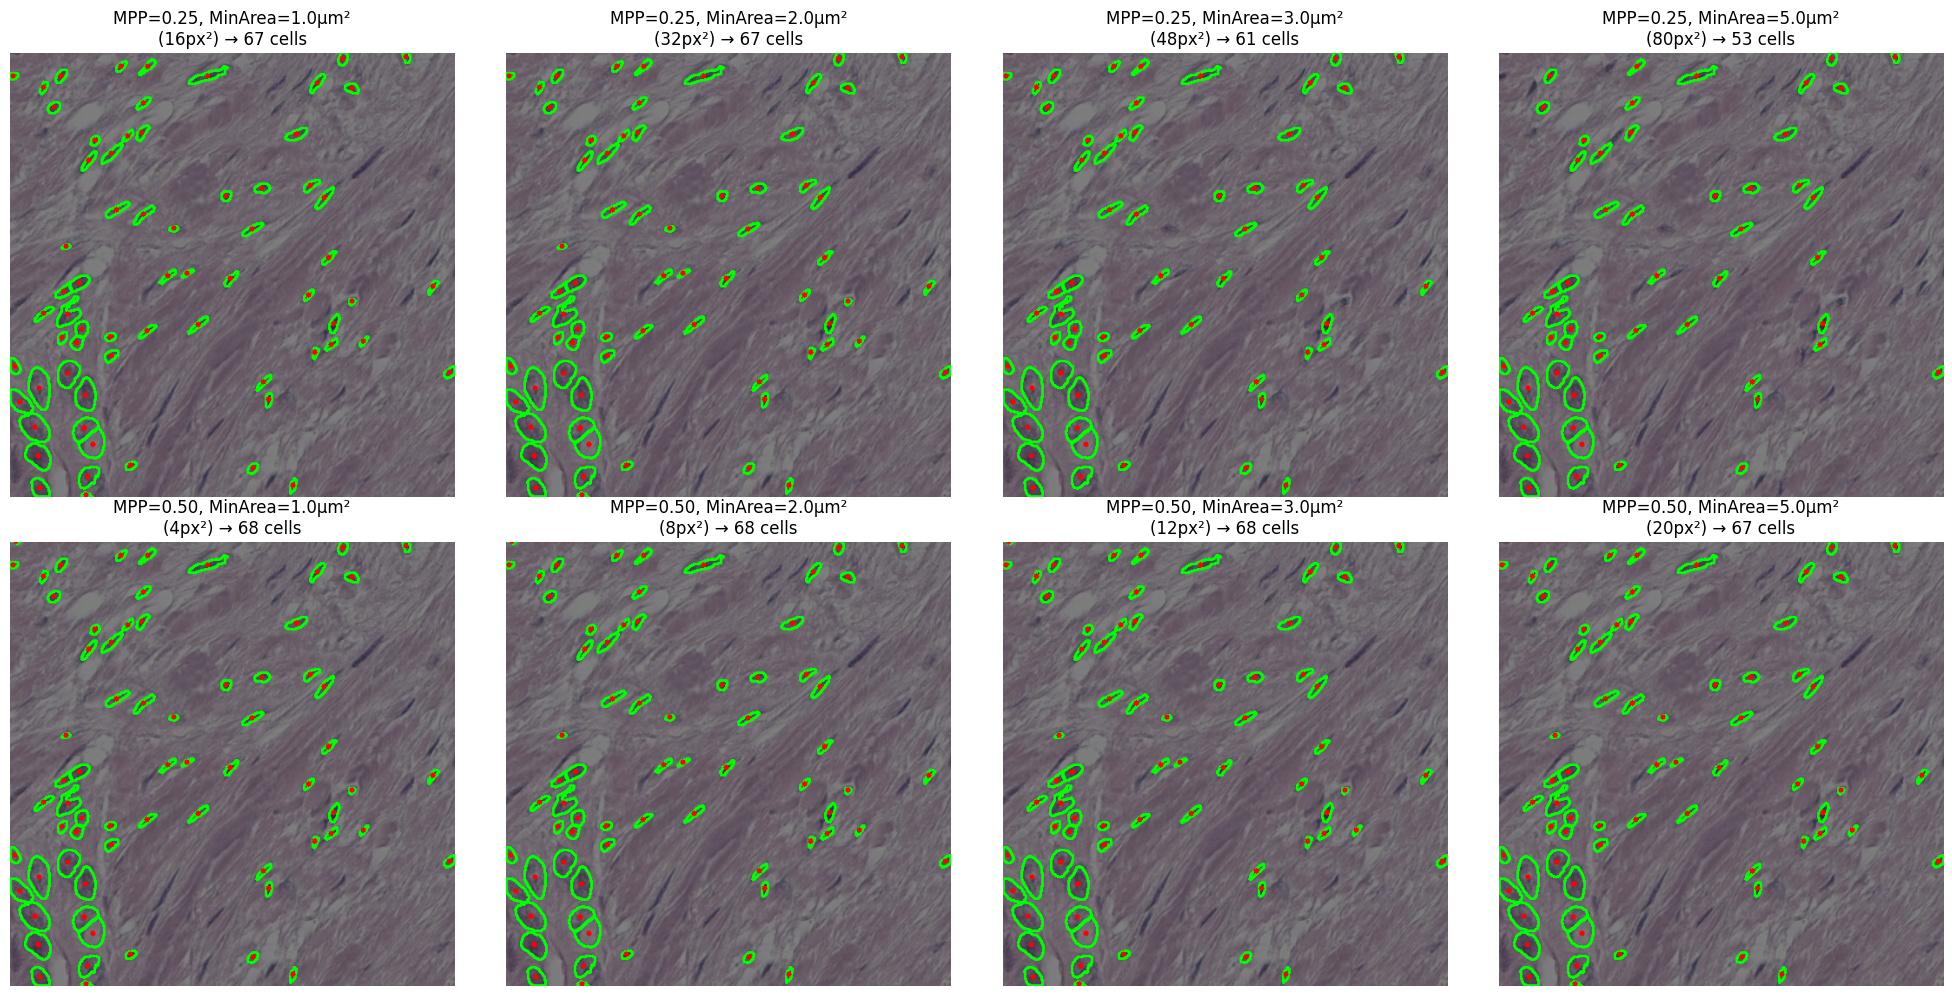


AREA DISTRIBUTIONS (in μm²):

MPP = 0.25 μm/px:
  Area range: 2.1 - 54.1 μm²
  Mean: 12.0 μm²
  Median: 8.0 μm²

MPP = 0.50 μm/px:
  Area range: 3.0 - 216.4 μm²
  Mean: 47.4 μm²
  Median: 31.5 μm²


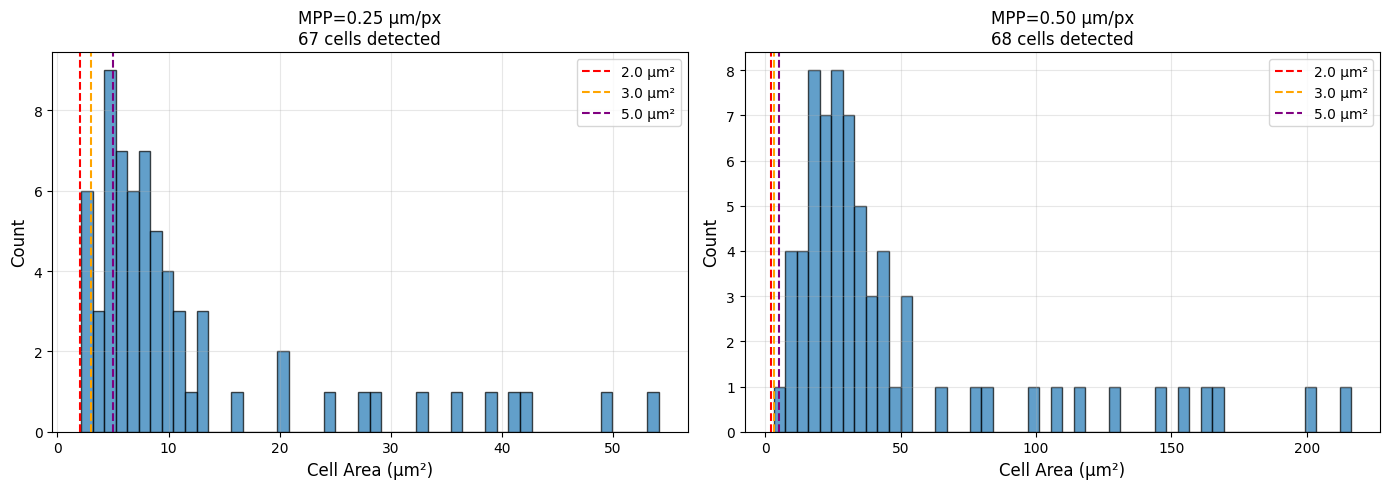


✅ Done! Check the saved images:
   - mpp_aware_filtering.png (shows effect of MPP + min_area_um)
   - area_distribution_microns.png (areas in biological units)

KEY INSIGHT: Same min_area_um (e.g., 3.0 μm²) adapts to different MPPs automatically!


In [8]:
# Complete test with MPP-aware filtering
import numpy as np
import matplotlib.pyplot as plt
from vitaminp.postprocessing.hv_postprocess import process_model_outputs
import cv2
import torch
from vitaminp import prepare_he_input, SimplePreprocessing

# 1. Load image and run model
tile = predictor.wsi_handler.get_wsi_reader('test_images/CRC31-he_chunk_38.png')
tile_img = tile.read_region((0, 0), (512, 512))
tile.close()

# Prepare input
tile_tensor = torch.from_numpy(tile_img.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to('cuda')
tile_tensor = prepare_he_input(tile_tensor)
tile_tensor = SimplePreprocessing().percentile_normalize(tile_tensor)

# Run model
with torch.no_grad():
    outputs = model(tile_tensor)

seg_pred = outputs['he_nuclei_seg'][0, 0].cpu().numpy()
h_map = outputs['he_nuclei_hv'][0, 0].cpu().numpy()
v_map = outputs['he_nuclei_hv'][0, 1].cpu().numpy()

# 2. Test different combinations with MPP-aware filtering
binary_thresholds = [0.5, 0.7]
min_area_um_values = [1.0, 2.0, 3.0, 5.0]  # ← Changed to microns!
mpp_values = [0.25, 0.5]  # Test different pixel sizes

results = {}

print("Testing binary_threshold + min_area_um + MPP combinations:")
print("=" * 100)
print(f"{'Binary':<8} {'MPP':<8} {'min_area_um':<12} {'min_px²':<10} {'Before':<8} {'After':<8} {'Removed':<8}")
print("-" * 100)

for bin_thresh in binary_thresholds:
    for mpp in mpp_values:
        for min_area_um in min_area_um_values:
            # Use the new process_model_outputs with MPP
            instance_map, inst_info, num_instances = process_model_outputs(
                seg_pred=seg_pred,
                h_map=h_map,
                v_map=v_map,
                magnification=40,
                mpp=mpp,
                binary_threshold=bin_thresh,
                min_area_um=min_area_um,
                use_gpu=True
            )
            
            # Get unfiltered count for comparison
            instance_map_raw, inst_info_raw, num_raw = process_model_outputs(
                seg_pred=seg_pred,
                h_map=h_map,
                v_map=v_map,
                magnification=40,
                mpp=mpp,
                binary_threshold=bin_thresh,
                min_area_um=None,  # No filtering
                use_gpu=True
            )
            
            min_area_pixels = min_area_um / (mpp ** 2)
            removed = num_raw - num_instances
            
            key = f"thresh={bin_thresh:.1f}_mpp={mpp:.2f}_area={min_area_um:.1f}"
            results[key] = {
                'num_before': num_raw,
                'num_after': num_instances,
                'inst_info': inst_info
            }
            
            print(f"{bin_thresh:<8.1f} {mpp:<8.2f} {min_area_um:<12.1f} {min_area_pixels:<10.0f} "
                  f"{num_raw:<8d} {num_instances:<8d} {removed:<8d}")

# 3. Visualize best combinations
print("\n" + "=" * 100)
print("CREATING VISUALIZATIONS...")
print("=" * 100)

fig, axes = plt.subplots(len(mpp_values), len(min_area_um_values), 
                         figsize=(20, 10))

bin_thresh = 0.7  # Use fixed threshold for visualization

for i, mpp in enumerate(mpp_values):
    for j, min_area_um in enumerate(min_area_um_values):
        key = f"thresh={bin_thresh:.1f}_mpp={mpp:.2f}_area={min_area_um:.1f}"
        
        # Create visualization
        vis_img = (tile_img.copy() * 0.5).astype(np.uint8)
        
        # Draw contours
        inst_info = results[key]['inst_info']
        for inst_id, data in inst_info.items():
            contour = data['contour'].reshape(-1, 1, 2).astype(np.int32)
            cv2.drawContours(vis_img, [contour], -1, (0, 255, 0), 2)
            
            # Draw centroid
            centroid = data['centroid'].astype(int)
            cv2.circle(vis_img, tuple(centroid), 3, (255, 0, 0), -1)
        
        ax = axes[i, j] if len(mpp_values) > 1 else axes[j]
        ax.imshow(vis_img)
        min_px = min_area_um / (mpp ** 2)
        ax.set_title(f'MPP={mpp:.2f}, MinArea={min_area_um:.1f}μm²\n'
                     f'({min_px:.0f}px²) → {results[key]["num_after"]} cells')
        ax.axis('off')

plt.tight_layout()
plt.savefig('mpp_aware_filtering.png', dpi=150, bbox_inches='tight')
plt.show()

# 4. Show area distributions
print("\n" + "=" * 100)
print("AREA DISTRIBUTIONS (in μm²):")
print("=" * 100)

fig, axes = plt.subplots(1, len(mpp_values), figsize=(14, 5))

for idx, mpp in enumerate(mpp_values):
    key = f"thresh=0.7_mpp={mpp:.2f}_area=1.0"  # Get all cells
    inst_info = results[key]['inst_info']
    
    if inst_info:
        areas_um = [data.get('area_um', 0) for data in inst_info.values()]
        
        ax = axes[idx] if len(mpp_values) > 1 else axes
        ax.hist(areas_um, bins=50, edgecolor='black', alpha=0.7)
        ax.axvline(2.0, color='red', linestyle='--', label='2.0 μm²')
        ax.axvline(3.0, color='orange', linestyle='--', label='3.0 μm²')
        ax.axvline(5.0, color='purple', linestyle='--', label='5.0 μm²')
        ax.set_xlabel('Cell Area (μm²)', fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.set_title(f'MPP={mpp:.2f} μm/px\n{len(areas_um)} cells detected')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Print statistics
        print(f"\nMPP = {mpp:.2f} μm/px:")
        print(f"  Area range: {min(areas_um):.1f} - {max(areas_um):.1f} μm²")
        print(f"  Mean: {np.mean(areas_um):.1f} μm²")
        print(f"  Median: {np.median(areas_um):.1f} μm²")

plt.tight_layout()
plt.savefig('area_distribution_microns.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Done! Check the saved images:")
print("   - mpp_aware_filtering.png (shows effect of MPP + min_area_um)")
print("   - area_distribution_microns.png (areas in biological units)")
print("\nKEY INSIGHT: Same min_area_um (e.g., 3.0 μm²) adapts to different MPPs automatically!")